# 将SelectiveSearch划分的区域处理为Tfrecords
因为SelectiveSearch划分一张图片都比较慢，所以考虑到电脑性能, 将SelectiveSearch划分的区域直接保存到Tfrecords中

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import selectivesearch
import matplotlib.patches as mpatches
import itertools

## 1. 读入制作好的车辆训练目标检测数据集

In [2]:
# 创建一个描述器
image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'channels': tf.io.FixedLenFeature([], tf.int64),
    'bboxes': tf.io.FixedLenSequenceFeature([4], tf.float32, allow_missing=True),  # 用float存的原因是方便后面归一化, 也可以在存之前就归一化
    'labels': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
    'labels_text': tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True),
    'image_name': tf.io.FixedLenFeature([], tf.string),
}

In [3]:
def parse_image_function(example_proto):
    # 把Example转为dict
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [4]:
ds_path = r".\data\PASCAL_VOC_2007_OBJ_car_train.tfrecords"
ds = tf.data.TFRecordDataset(ds_path).map(parse_image_function, num_parallel_calls = tf.data.experimental.AUTOTUNE) \
                                        .prefetch(tf.data.experimental.AUTOTUNE)

tf.Tensor(b'000012', shape=(), dtype=string)
tf.Tensor([[156.  97. 351. 270.]], shape=(1, 4), dtype=float32)
tf.Tensor([b'car'], shape=(1,), dtype=string)


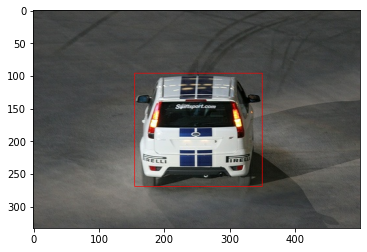

tf.Tensor(b'000026', shape=(), dtype=string)
tf.Tensor([[ 90. 125. 337. 212.]], shape=(1, 4), dtype=float32)
tf.Tensor([b'car'], shape=(1,), dtype=string)


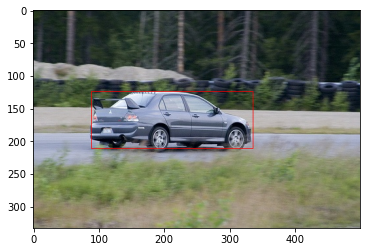

In [5]:
for d in ds.take(2):
    print(d["image_name"])
    img = tf.image.decode_jpeg(d["image_raw"])
    bboxes = d["bboxes"]
    print(bboxes)
    print(d["labels_text"])
    width = tf.cast(d["width"], tf.float32)
    height = tf.cast(d["height"], tf.float32)
    # 绘制bboxes, 注意用tf绘制bbox与cv不一样，前者要求img和bbox均归一化
    img = tf.expand_dims(img, 0)  # Tensoflow是按照batch的方式绘制bbox，所以添加一个batch的坐标轴
    img = tf.cast(img, tf.float32) / 255.  # 归一化
    bboxes = bboxes.numpy()
    bboxes[:, 0::2] /= width
    bboxes[:, 1::2] /= height
    # Tensorflow 绘制的时候是ymin, xmin, ymax, xmax
    bboxes[:, [0, 1]] = bboxes[:, [1, 0]]
    bboxes[:, [2, 3]]  = bboxes[:, [3, 2]]
    bboxes = tf.expand_dims(bboxes, 0)
    img = tf.image.draw_bounding_boxes(img, bboxes, np.array([[1.0, 0.0, 0.0]]))
    plt.imshow(tf.squeeze(img))
    plt.show()

## 2. 用selectivesearch划分图片

### 2.1 看一看分割效果

In [6]:
def selective_search(img, max_num = 50, scale=500, sigma=0.9, min_size=20):
    img_lbl, regions = selectivesearch.selective_search(
        img, scale, sigma, min_size=20)
    #计算利用Selective Search算法得到了多少个候选区域
#     print(len(regions))
    #创建一个集合 元素不会重复，每一个元素都是一个list(左上角x，左上角y,宽,高)，表示一个候选区域的边框
    candidates = set()
    for r in regions:
        if len(candidates) == max_num:
            break
        #排除重复的候选区
        if r['rect'] in candidates:
            continue
        #排除小于 2000 pixels的候选区域(并不是bounding box中的区域大小)  
        if r['size'] < 2000:
            continue
        #排除扭曲的候选区域边框  即只保留近似正方形的
#         x, y, w, h = r['rect']
#         if w / h > 1.2 or h / w > 1.2:
#             continue
        x, y, w, h = r['rect']
        candidates.add((x, y, x + w, y + h))
        # 处理为list, 方便转为ndarray
        region_proposal = []
        for candidate in candidates:
            region_proposal.append(list(candidate))
    return region_proposal

candi 50


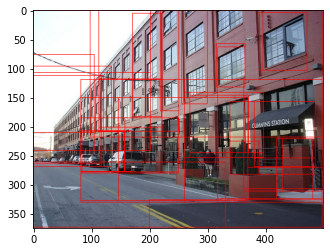

In [7]:
for idx, d in enumerate(ds.take(5)):  # 这张图片难以辨认
    if idx != 4:
        continue
    img = tf.image.decode_jpeg(d["image_raw"])
    width = d["width"]
    height = d["height"]
    candidates = selective_search(img, 50)
    print("candi", len(candidates))
    bboxes = []
    for xmin, ymin, xmax, ymax in candidates:
        bbox = [ymin / height, xmin / width, ymax / height, xmax / width]  # 暂时按照TensorFlow的方式储存 ymin, xmin, ymax, xmax
        bboxes.append(bbox)
    bboxes = np.array(bboxes)
    bboxes = np.expand_dims(bboxes, 0)  # 添加batch轴
    img = tf.expand_dims(img, 0)
    img = tf.cast(img, tf.float32) / 255.  # 归一化
    # 绘制bbox
    img = tf.image.draw_bounding_boxes(img, bboxes, np.array([[1.0, 0.0, 0.0]]))
    plt.imshow(tf.squeeze(img))
    plt.show()

### 2.2 开始给region proposal添加label
按照原论文以与ground truth的IOU >= 0.5为界线进行标记, 满足则为正样本(1, 车辆)， 不满足则为负样本(0, 背景)

#### 2.2.1 编写工具函数

In [8]:
# 计算IOU
def _iou(bbox1, bbox2):
    """
        bbox的格式为xmin, ymin, xmax, ymax
    """
    xmin_1, ymin_1, xmax_1, ymax_1 = bbox1
    xmin_2, ymin_2, xmax_2, ymax_2 = bbox2
    bxmin = max(xmin_1, xmin_2)
    bymin = max(ymin_1, ymin_2)
    bxmax = min(xmax_1, xmax_2)
    bymax = min(ymax_1, ymax_2)
    bwidth = max(bxmax - bxmin, 0)
    bheight = max(bymax - bymin, 0)
    inter = bwidth * bheight
    union = (xmax_1 - xmin_1) * (ymax_1 - ymin_1) + (xmax_2 - xmin_2) * (ymax_2 - ymin_2) - inter
    return inter / union

In [9]:
# 测试一下
bbox1 = [1, 1, 4, 4]
bbox2 = [1, 1, 7, 7]
_iou(bbox1, bbox2)

0.25

In [10]:
# tfrecords辅助函数
def _bytes_feature(value):
    if not isinstance(value, list):
        value = [value]
    for idx, v in enumerate(value):
        if isinstance(v, str):  # 字符串转bytes
            value[idx] = v.encode()
        if isinstance(v, type(tf.constant(0))):
            value[idx] = v.numpy()  # BytesList won't unpack a string from an EagerTensor.
            if isinstance(value[idx], type(np.array([0]))):
                value[idx] = value[idx].tobytes()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    if not isinstance(value, (tuple, list)):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

In [11]:
# tfrecords辅助函数
def convert_to_example(d, regions, regions_label):
    """
    regions 是ndarray
    regions_label 是list
    """
    image_name, image_data, bboxes, labels, labels_text = d["image_name"], d["image_raw"], d["bboxes"], d["labels"], d["labels_text"]
    regions = regions.flatten()
    regions = regions.tolist()
    image_format = b'JPEG'
    bboxes = tf.reshape(bboxes, [-1,])  # 拉直bboxes
    example = tf.train.Example(features = tf.train.Features(feature={
        'bboxes': _float_feature(bboxes.numpy().tolist()),  # 用float存的原因是方便后面归一化, 也可以在存之前就归一化
        'labels': _int64_feature(labels.numpy().tolist()),
        'labels_text': _bytes_feature(labels_text.numpy().tolist()),
        'format': _bytes_feature(image_format),
        'image_raw': _bytes_feature(image_data),
        'image_name': _bytes_feature(image_name),
        'regions': _float_feature(regions),
        'regions_label': _int64_feature(regions_label)
    }))
    return example

#### 2.2.2 开始写入tfrecords

In [12]:
out_dir = r".\data\PASCAL_VOC_2007_OBJ_car_train_regions.tfrecords"
with tf.io.TFRecordWriter(out_dir) as writer:
    for idx, d in enumerate(ds):
        # ground truth
        bboxes = d["bboxes"]
        # 划分候选区域
        img = tf.image.decode_jpeg(d["image_raw"])
        candidates = selective_search(img, 100)
        candidates = np.array(candidates)
        # 给regions贴标签
        regions_label = []
        # Hints: 这里不能用itertools.product笛卡尔积循环, 不然会导致一个region出现多个标签的情况
        for region in candidates:
            for bbox in bboxes:
                iou = _iou(region, bbox)
                if iou >= 0.5:
                    regions_label.append(1)  # 候选区域是汽车
                    break 
                else:
                    regions_label.append(0)  # 候选区域是背景
                    break 
            continue  # 防止一个region出现多个标签的情况
        assert len(candidates) == len(regions_label)
        example = convert_to_example(d, candidates, regions_label)
        writer.write(example.SerializeToString())
        if (idx+1) % 100 == 0:
            print(idx+1, "finished")

100 finished
200 finished
300 finished


#### 2.2.3 测试写成功没有

In [13]:
# 创建一个描述器
image_feature_description2 = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'bboxes': tf.io.FixedLenSequenceFeature([4], tf.float32, allow_missing=True),  # 用float存的原因是方便后面归一化, 也可以在存之前就归一化
    'labels': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
    'labels_text': tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'regions': tf.io.FixedLenSequenceFeature([4], tf.float32, allow_missing=True),
    'regions_label':tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True)
}
def parse_image_function2(example_proto):
    # 把Example转为dict
    return tf.io.parse_single_example(example_proto, image_feature_description2)

bboxes tf.Tensor([[156.  97. 351. 270.]], shape=(1, 4), dtype=float32)
regions tf.Tensor(
[[155.  94. 346. 161.]
 [165. 150. 318. 252.]
 [312. 139. 391. 268.]
 [217. 101. 346. 156.]
 [185. 241. 303. 268.]
 [155.  94. 346. 177.]
 [316. 111. 499. 332.]
 [  0.   0. 499. 332.]
 [155.  94. 391. 285.]
 [165. 104. 329. 252.]
 [184. 180. 318. 242.]
 [217.  94. 346. 156.]
 [396. 237. 499. 332.]
 [155.  94. 391. 268.]
 [185. 139. 391. 268.]
 [337. 139. 499. 332.]
 [337. 139. 499. 254.]
 [193. 141. 305. 177.]
 [165. 150. 274. 252.]
 [302. 139. 391. 268.]
 [165. 104. 318. 252.]
 [204.  94. 346. 156.]], shape=(22, 4), dtype=float32)
regions_label tf.Tensor([0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0], shape=(22,), dtype=int64)
image_name tf.Tensor(b'000012', shape=(), dtype=string)


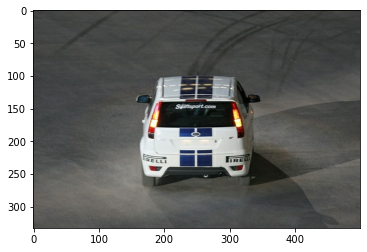

bboxes tf.Tensor([[ 90. 125. 337. 212.]], shape=(1, 4), dtype=float32)
regions tf.Tensor(
[[ 41. 168. 332. 216.]
 [ 89. 173. 332. 216.]
 [  0.  79. 360. 150.]
 [ 85. 125. 387. 212.]
 [ 86. 127. 387. 200.]
 [ 85. 125. 387. 200.]
 [ 59.   0. 222.  92.]
 [  0.   0. 499. 332.]
 [ 85. 124. 387. 212.]
 [ 89. 168. 332. 216.]
 [  0.  79. 499. 242.]
 [  0. 150.  92. 175.]
 [290. 154. 499. 179.]
 [  0. 197. 188. 242.]
 [ 86. 125. 387. 200.]
 [ 90. 127. 387. 200.]
 [  0.  79. 499. 332.]
 [  0. 190. 499. 332.]
 [  0. 168. 332. 216.]
 [ 59.   0. 499. 153.]
 [  0. 124. 499. 242.]
 [  0.  79. 360. 147.]
 [434.   0. 499. 108.]
 [  0.   0.  52.  80.]
 [177.   0. 499. 153.]
 [328.   0. 434. 107.]
 [  0.   0.  51.  80.]
 [  0.  79. 236. 147.]
 [ 85. 124. 499. 212.]], shape=(29, 4), dtype=float32)
regions_label tf.Tensor([0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(29,), dtype=int64)
image_name tf.Tensor(b'000026', shape=(), dtype=string)


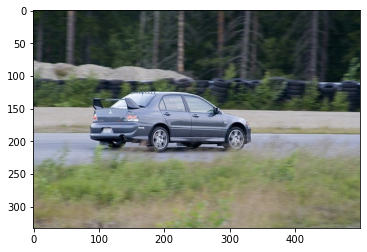

In [ ]:
ds2 = tf.data.TFRecordDataset(out_dir).map(parse_image_function2)
for d in ds2.take(5):
    print("===================")
    print("bboxes", d["bboxes"])
    print("regions", d["regions"])
    print("regions_label", d["regions_label"])
    print("image_name", d["image_name"])
    assert len(d["regions_label"]) == len(d["regions"])
    img = tf.image.decode_jpeg(d["image_raw"])
    plt.imshow(img)
    plt.show()